In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor

In [2]:
plt.rcParams['figure.figsize'] = [15, 5]

In [3]:
path_to_file = 'fifaindex.com/players_2.csv'
random_state = 42

# Препроцессинг и постпроцессинг

In [4]:
def preprocess(*args):
    """
    params: 
        args - name of columns that must be deleted
    """
    df = pd.read_csv(path_to_file, encoding='utf-32')
    df['height'] = df['height'].map(lambda x: int(x.replace('cm', '')))
    df['weight'] = df['weight'].map(lambda x: int(x.replace('kg', '')))
    df['market value'] = df['market value'].map(lambda x: str(x).replace('.', '').replace('€', ''))
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
    int_cols = list(df.columns)
    int_cols.remove('name')
    for col in int_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce', downcast='integer')
    df.fillna(0, inplace=True)
    df.drop([*args], axis=1, inplace=True)
    return df


df = preprocess()
df

,name,height,weight,age,market value,ball control,dribbling,slide tackle,stand tackle,aggression,...,agility,jumping,heading,shot power,finishing,long shots,curve,fk acc.,penalties,volleys
0,Kylian Mbappé,182,73,24,153500000.0,91,93,32,34,64,...,93,77,72,88,93,82,80,69,84,83
1,Kevin De Bruyne,181,75,31,107500000.0,90,86,53,66,75,...,76,63,55,92,85,91,89,83,83,83
2,Robert Lewandowski,185,81,34,84000000.0,89,85,19,42,81,...,77,85,91,91,94,84,79,85,90,89
3,Karim Benzema,185,81,35,64000000.0,91,87,18,24,63,...,78,79,90,87,92,80,82,73,84,88
4,Lionel Messi,169,67,35,54000000.0,93,95,24,35,44,...,91,68,70,86,90,91,93,93,75,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15954,Ben Collins,191,89,23,50000.0,33,24,56,52,49,...,41,76,43,39,16,15,22,24,31,25
15955,Bijoy Varghese,181,79,23,50000.0,32,23,50,51,43,...,41,68,46,38,18,18,26,26,31,28
15956,Gurkirat Singh,175,70,19,50000.0,50,50,25,16,30,...,70,55,30,55,55,53,38,28,50,32
15957,Chen Xiangyu,186,70,21,50000.0,46,43,14,16,24,...,42,56,53,45,55,40,35,32,56,43


In [5]:
def get_selection(df, random_state=42):
    X = df.drop(['market value'], axis=1)
    y = df['market value']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    names_train = X_train['name'] 
    X_train.drop(['name'], axis=1, inplace=True)
    names_test = X_test['name'] 
    X_test.drop(['name'], axis=1, inplace=True)
    return X_train.values, y_train.values, names_train.values, X_test.values, y_test.values, names_test.values

Text(0, 0.5, 'count players')

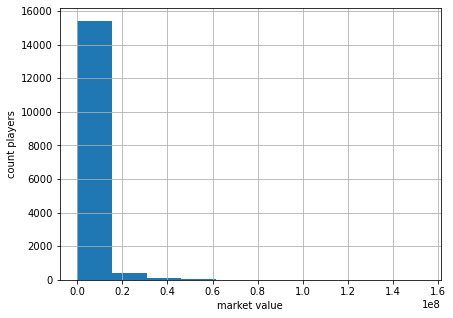

In [6]:
plt.subplot(1, 2, 1)
df['market value'].hist()
plt.xlabel('market value')
plt.ylabel('count players')

Text(0, 0.5, 'count players')

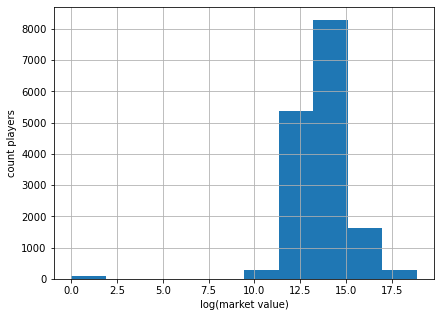

In [7]:
plt.subplot(1, 2, 1)
df['market value'].map(lambda x: np.log(x) if x >0 else 0).hist()
plt.xlabel('log(market value)')
plt.ylabel('count players')

In [8]:
#sns.heatmap(df.corr())

In [9]:
def make_graph(y_test, y_predict, title=None):
    plt.scatter(y_test, y_predict, alpha=0.6, s=30)
    mn = min( y_test.min(), y_predict.min() )
    mx = max( y_test.max(), y_predict.max() )
    plt.xlabel('y test')
    plt.ylabel('y predict')
    plt.xlim([mn, mx])
    plt.ylim([mn, mx])
    plt.plot([0, mx], [0, mx], label='x=y', color='red', linewidth=2)
    plt.grid()
    plt.legend()
    if title:
        plt.title(title)

In [10]:
def validate_model(model, data, log_scale=False, scale = False, rounding=3):
    """
    params: 
            log_scale - if True make 2 graphs and recalculates metrics to the initial dimension
            scale     - if True normalize X to [0 - 1]
            rounding  - the number of decimal places in metrics
    """
    X_train, y_train, names_train, X_test, y_test, names_test = get_selection(data)
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)    
    y_test_for_score = y_test
    plt.subplot(1, 2, 1)
    if log_scale:
        make_graph(y_test, y_predict, 'log scale')
        y_predict = np.exp(y_predict)
        y_test = np.exp(y_test)
        plt.subplot(1, 2, 2)
        make_graph(y_test, y_predict)
        y_test_for_score = np.log(y_test)
    else:
        make_graph(y_test, y_predict)
    plt.show()
    
    MAE = metrics.mean_absolute_error(y_test,y_predict)
    MSE = metrics.mean_squared_error(y_test,y_predict)
    RMSE = np.sqrt(MSE)
    
    print(f'max error = {round(np.max( np.abs( y_test - y_predict) ) / 1e8, 2) } * 1e8')
    print(f'MAE   = {round(MAE / 1e8, rounding)} * 1e8')
    print(f'RMSE  = {round(RMSE / 1e8, rounding)} * 1e8')
    print(f'MSE   = {MSE}')
    print(f'score = {round(model.score(X_test, y_test_for_score), 4)}')
    return model

In [11]:
def find_hyperparameters(model, data, grid_space):
    grid = GridSearchCV(model, param_grid=grid_space, cv=3, n_jobs=-1)
    X_train, y_train, names_train, X_test, y_test, names_test = get_selection(data)
    model_grid = grid.fit(X_train,y_train)
    print('Best hyperparameters are: '+str(model_grid.best_params_))
    print('Best score is: '+str(model_grid.best_score_))
    return model_grid.best_params_

In [12]:
def get_coef(model, data, algoritm = 'linear'):
    if algoritm == 'linear':
        table = pd.DataFrame(model.coef_, data.drop(['name', 'market value'], axis=1).columns, columns=['coef']).sort_values(by='coef', ascending=False)
    if algoritm == 'tree':
        table = pd.DataFrame(model.feature_importances_, data.drop(['name', 'market value'], axis=1).columns, columns=['coef']).sort_values(by='coef', ascending=False)
    return table

In [13]:
# create data frames

df_log = preprocess()
df_pos = df_log[df_log['market value'] > 0]
df_log['market value'] = df_log['market value'].map(lambda x: np.log(x) if x >0 else 0)
df_log_pos = df_log[df_log['market value'] > 0]

# 1. Линейная регрессия

<h3>Обычная линейная регрессия</h3> <br>
Низкая точность модели из-за неравномерного распределения market value (малый процент игроков с большим market value)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


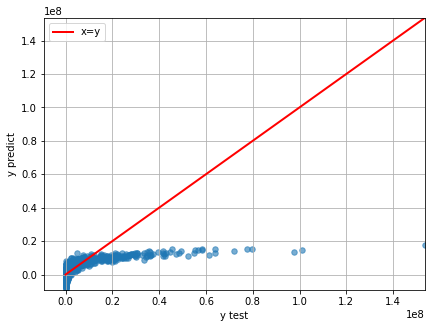

max error = 1.36 * 1e8
MAE   = 0.028 * 1e8
RMSE  = 0.059 * 1e8
MSE   = 35390228071190.305
score = 0.3292


LinearRegression(normalize=True)

In [22]:
regression = LinearRegression(copy_X=True, normalize=True)
validate_model(regression, df)

In [23]:
regression

LinearRegression(normalize=True)

<h3>Обычная линейная регрессия, предсказание логарифма market value</h3> <br>
Как видно из графика выше, распределение log(market value) похоже на нормальное распределение. Точность модели значительно улучшилась при предсказании логарифма целевой переменной. В выборке было около 120 игроков с market value = Nan (которым присвоилось значение 0). При исключении этих игроков, точность модели еще значительно выросла. Поэтому далее прогнозируется без учета этих 120 игроков (df_log_pos)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


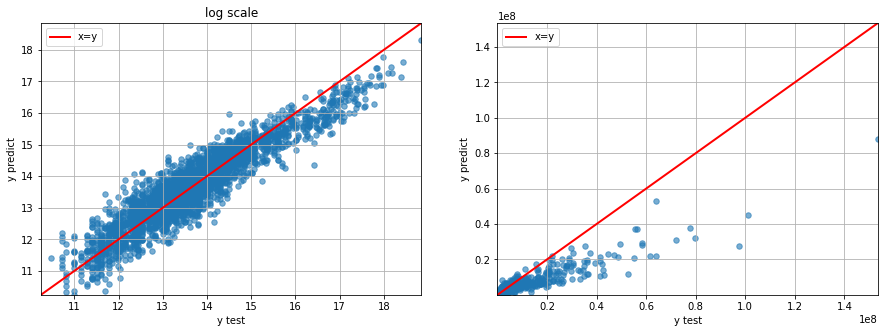

max error = 0.7 * 1e8
MAE   = 0.011 * 1e8
RMSE  = 0.04 * 1e8
MSE   = 16339561810808.773
score = 0.8588


,reactions,ball control,short pass,composure,heading,sprint speed,acceleration,strength,finishing,crossing,...,balance,penalties,agility,height,interceptions,long shots,vision,long pass,att. position,age
coef,0.062159,0.034249,0.027935,0.018125,0.013096,0.009834,0.008893,0.007974,0.007263,0.007091,...,-0.001179,-0.001293,-0.001805,-0.002269,-0.003357,-0.005583,-0.006458,-0.00653,-0.009677,-0.036781


In [16]:
# log 
regression = LinearRegression(copy_X=True, normalize=True)
validate_model(regression, df_log_pos, log_scale=True)
get_coef(regression, df_log_pos, algoritm='linear').transpose()

<h3> Lasso </h3> <br>
Регрессия с регуляризацией не дает улучшения модели, тк видно, что коэффициенты изначальной линейной регрессии небольшие. Оптимальный гиперпараметр alpha стремится к 0

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


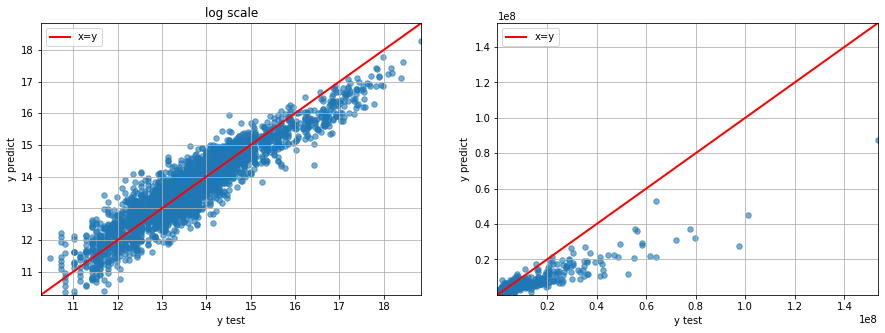

max error = 0.7 * 1e8
MAE   = 0.011 * 1e8
RMSE  = 0.041 * 1e8
MSE   = 16499615140425.207
score = 0.8589


,reactions,ball control,short pass,composure,heading,sprint speed,acceleration,strength,crossing,finishing,...,jumping,balance,penalties,agility,interceptions,long shots,long pass,vision,att. position,age
coef,0.062004,0.034266,0.027278,0.017781,0.01301,0.009924,0.008788,0.007803,0.006774,0.006722,...,-0.000624,-0.00082,-0.000959,-0.001546,-0.002923,-0.005256,-0.00587,-0.006308,-0.009212,-0.035936


In [17]:
# Lasso
grid_space = {
    'alpha': [1] + [i * 0.01 for i in range(1, 5)],
    'fit_intercept': [True, False],
    'max_iter': [1000, 500, 200],
    'random_state': [random_state],
    'positive': [True, False]
}

#params = find_hyperparameters(Lasso(), df_log_pos, grid_space=grid_space)
params = {'alpha': 0.01, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'random_state': 42}
lasso = Lasso(**params)
lasso = validate_model(lasso, df_log_pos, log_scale=True)
get_coef(lasso, df_log_pos, algoritm='linear').transpose()

In [24]:
Lasso?

### Ridge 
Модель с регуляризацией. Аналогичная ситуация, только от alpha результат практически не зависит

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


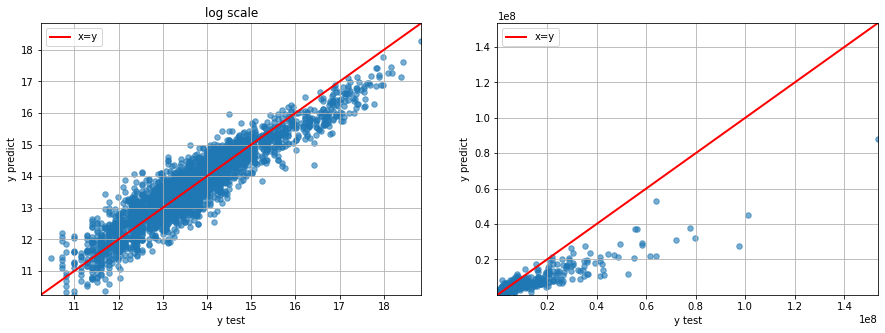

max error = 0.7 * 1e8
MAE   = 0.011 * 1e8
RMSE  = 0.04 * 1e8
MSE   = 16349013981134.018
score = 0.8588


,reactions,ball control,short pass,composure,heading,sprint speed,acceleration,strength,finishing,crossing,...,balance,penalties,agility,height,interceptions,long shots,vision,long pass,att. position,age
coef,0.062127,0.034234,0.027927,0.018127,0.013101,0.009836,0.008896,0.00797,0.00726,0.007085,...,-0.001177,-0.001291,-0.001805,-0.002254,-0.003353,-0.005582,-0.006454,-0.006518,-0.009671,-0.036739


In [18]:
# Ridge

grid_space = {
    'alpha': [1] + [i * 5 for i in range(20, 35)],
    'fit_intercept': [True, False],
    'max_iter': [1000, 3000, 2000],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'random_state': [random_state]
}

#params = find_hyperparameters(Ridge(), df_log_pos, grid_space=grid_space)
params = {'alpha': 170, 'fit_intercept': True, 'max_iter': 1000, 'random_state': 42, 'solver': 'auto'}
ridge = Ridge(**params)
ridge = validate_model(ridge, df_log_pos, log_scale=True)
get_coef(ridge, df_log_pos, algoritm='linear').transpose()


### lasso_cv
Модель с регуляризацией. Аналогичная ситуация

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


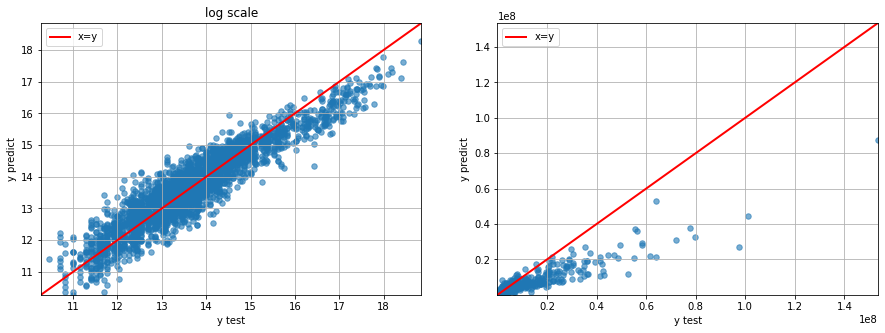

max error = 0.7 * 1e8
MAE   = 0.011 * 1e8
RMSE  = 0.041 * 1e8
MSE   = 16512194365330.256
score = 0.8589


LassoCV(normalize=True)

In [19]:
# lass0_cv
lasso_cv = LassoCV(copy_X=True, normalize=True)
validate_model(lasso_cv, df_log_pos, log_scale=True)

### Уменьшение количества признаков
Если попробовать убрать из фичей возраст, рост, вес или оставить только самые весомые фичи, то точность модели снижается

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


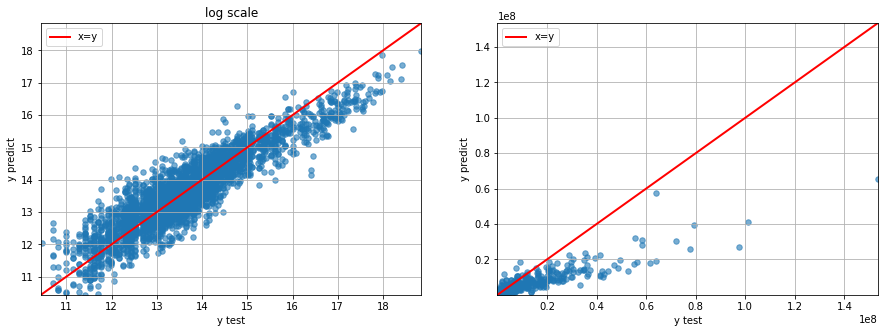

max error = 0.88 * 1e8
MAE   = 0.012 * 1e8
RMSE  = 0.045 * 1e8
MSE   = 20044190456453.7
score = 0.8185


LinearRegression(normalize=True)

In [20]:
less_colums = [col for col in df_log_pos.columns if col not in ['name', 'market value', 'reactions', 'ball control', 'short pass', 'composure', 'heading', 'age'] ]
df_less_col = preprocess(*less_colums)
df_less_col['market value'] = df_less_col['market value'].map(lambda x: np.log(x) if x > 0 else 0)
df_less_col = df_less_col[df_less_col['market value'] > 0 ]

regression = LinearRegression(copy_X=True, normalize=True)
validate_model(regression, df_less_col, log_scale=True)

# 2. Деревья

### Дерево решений
как и ожидалось деревья более устойчивы к выбросам. Точность прогнозирования целевой переменной деревом на уровне прогнозирования логарифма линейной регрессией

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


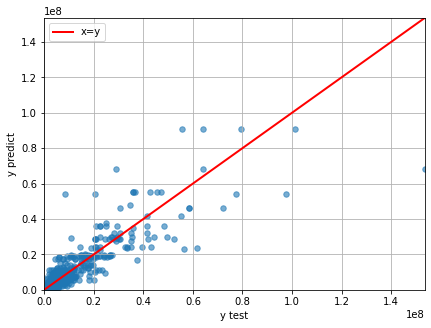

max error = 0.85 * 1e8
MAE   = 0.009 * 1e8
RMSE  = 0.032 * 1e8
MSE   = 10514448573491.781
score = 0.8007


In [25]:
grid_space = {
    'max_depth': [14, 16, 18, 11],
#    'criterion': ['mse', 'mae', 'friedman_mse', 'poisson'],
    'splitter': ['best'],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [8, 10 , 12, 14],
    'max_features': ["auto", "sqrt", "log2"],
    'max_leaf_nodes': [None, 2, 4, 6, 8]
    
}
#params = find_hyperparameters(DecisionTreeRegressor(random_state=random_state), df, grid_space=grid_space)
params = {'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 8, 'min_samples_split': 2, 'splitter': 'best'}

tree = DecisionTreeRegressor(**params, random_state=random_state)
tree = validate_model(tree, df, log_scale=False)

In [ ]:
tree.predict()

### Дерево решений, предсказание логарифма market value
Слабо меняется MAE и RMSE, ощутимый прирост score

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


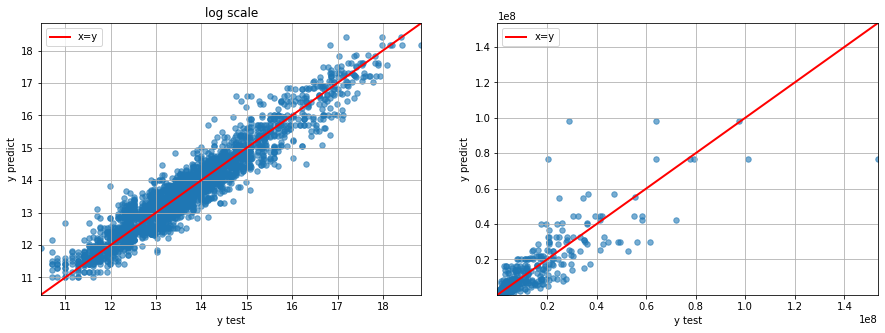

max error = 0.77 * 1e8
MAE   = 0.009 * 1e8
RMSE  = 0.034 * 1e8
MSE   = 11486166132807.096
score = 0.9069


In [22]:
grid_space = {
    'max_depth': [7, 9, 10, 11, None],
#    'criterion': ['mse', 'mae', 'friedman_mse', 'poisson'],
    'splitter': ['best'],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [2, 4, 6, 8],
    'max_features': ["auto", "sqrt", "log2"],
    'max_leaf_nodes': [None, 2, 4, 6, 8]
    
}

#params = find_hyperparameters(DecisionTreeRegressor(random_state=random_state), df_log_pos, grid_space=grid_space)
params = {'criterion': 'mae', 'max_depth': 14, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_samples_leaf': 8, 'min_samples_split': 2, 'splitter': 'best'}
tree = DecisionTreeRegressor(**params, random_state=random_state)
tree = validate_model(tree, df_log_pos, log_scale=True)

### Случайный лес 
уменьшение MAE, RMSE
увеличение score

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


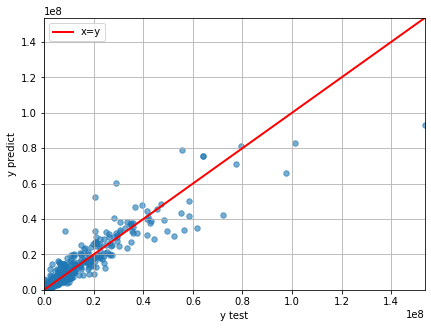

max error = 0.6 * 1e8
MAE   = 0.006 * 1e8
RMSE  = 0.024 * 1e8
MSE   = 5563389611525.689
score = 0.8945


RandomForestRegressor()

In [24]:
# Random Forest
forest = RandomForestRegressor()
validate_model(forest, df, log_scale=False)

### Случайный лес, прогнозирование логарифма market value

увеличене score

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


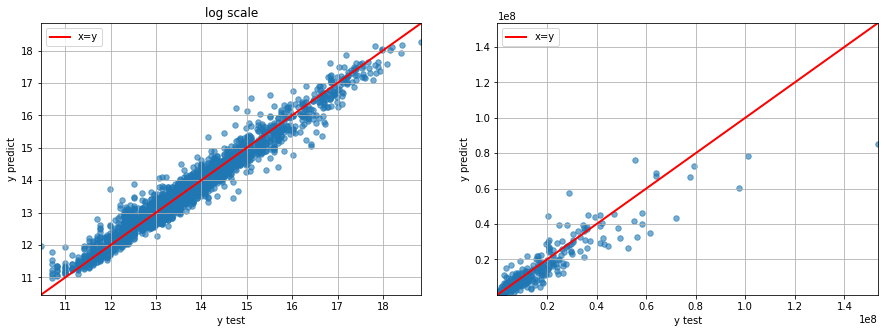

max error = 0.68 * 1e8
MAE   = 0.006 * 1e8
RMSE  = 0.025 * 1e8
MSE   = 6043332128548.831
score = 0.9561


In [60]:
# Random Forest

grid_space = {
#    'n_estimators': [300, 200],
#    'criterion': ["mse", "mae"],
#    'max_depth': [2, 4, 6, 8, None],
#    'max_features': ["auto", "sqrt", "log2"],
    'ccp_alpha': [0, 0.5, 1],
}
#params = find_hyperparameters(RandomForestRegressor(random_state=random_state), df_log_pos, grid_space=grid_space)
params = {'n_estimators': 300,}
forest = RandomForestRegressor(n_jobs=-1, random_state=random_state, **params)
forest = validate_model(forest, df_log_pos, log_scale=True)

### ExtraTrees

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


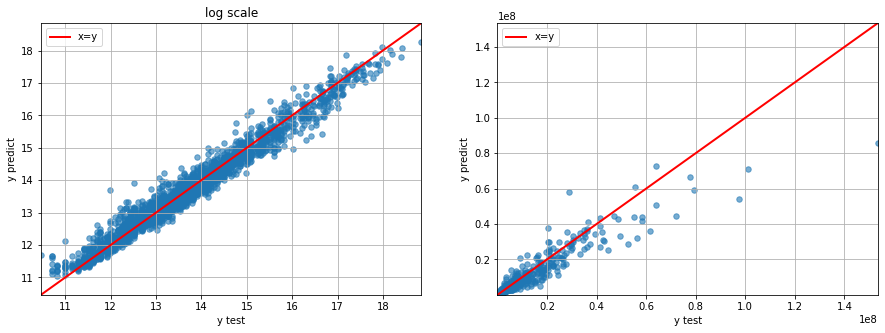

max error = 0.68 * 1e8
MAE   = 0.006 * 1e8
RMSE  = 0.024 * 1e8
MSE   = 5869405735497.131
score = 0.9635


ExtraTreesRegressor(n_estimators=300, random_state=42)

In [26]:
params = {'n_estimators': 300}
forest = ExtraTreesRegressor(random_state = random_state, **params)
validate_model(forest, df_log_pos, log_scale=True)

# 3. Градиентный бустинг

предсказание market value имеет высокий score

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


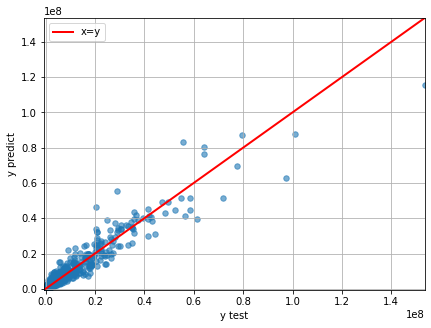

max error = 0.38 * 1e8
MAE   = 0.006 * 1e8
RMSE  = 0.02 * 1e8
MSE   = 4037614269576.7905
score = 0.9233


GradientBoostingRegressor()

In [27]:
boosting = GradientBoostingRegressor()
validate_model(boosting, df_pos, log_scale=False)

### предсказание логарифма market value
Увеличивается score <br>
увеличение n_estimators улучшает score, оптимальное значение n_estimators = 400

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


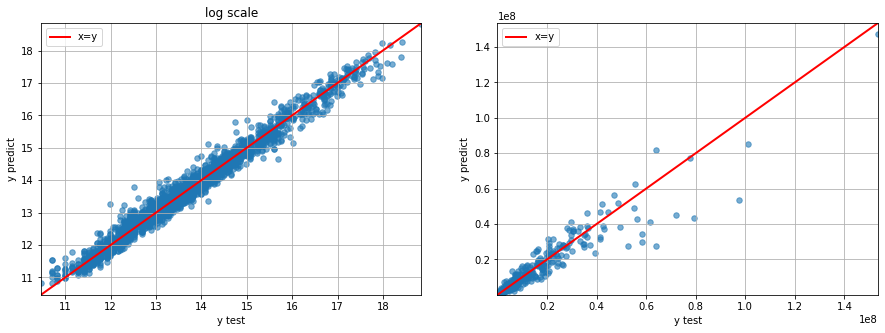

max error = 0.44 * 1e8
MAE   = 0.005 * 1e8
RMSE  = 0.02 * 1e8
MSE   = 4099665024832.509
score = 0.975


GradientBoostingRegressor(loss='huber', max_depth=6, n_estimators=400,
                          random_state=42, subsample=0.5)

In [63]:
grid_space = {
#    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'n_estimators': [100, 300, 400],
#    'criterion': ['friedman_mse', 'mse', 'mae'],
    'max_depth': [7,6, 8],
    'subsample': [1, 0.1, 0.5],
}
#params = find_hyperparameters(GradientBoostingRegressor(random_state=random_state), df_log_pos, grid_space=grid_space)
params = {'n_estimators': 400, 'max_depth': 6, 'subsample': 0.5, 'loss': 'huber', 'criterion': 'friedman_mse'}
boosting = GradientBoostingRegressor(random_state=random_state, **params)
validate_model(boosting, df_log_pos, log_scale=True, rounding = 3)

# 4. XGBoost

Схожий результат с градиентным бустингом, только работает быстрее

In [50]:
!pip install xgboost

In [32]:
import xgboost as xgb

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


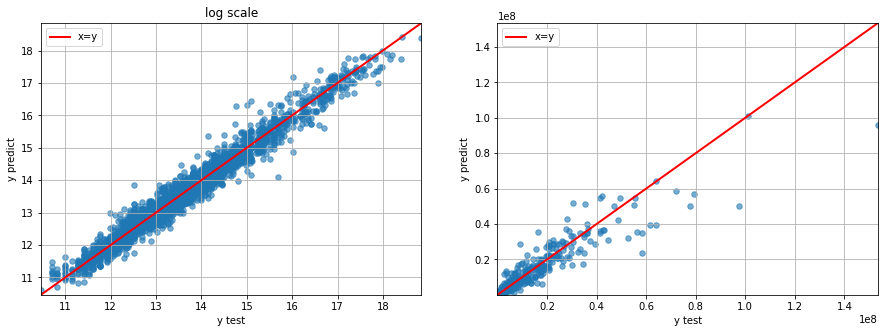

max error = 0.58 * 1e8
MAE   = 0.006 * 1e8
RMSE  = 0.024 * 1e8
MSE   = 5651546379837.047
score = 0.9634


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=400, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [33]:
params = {'n_estimators': 400, 'max_depth': 6, 'subsample': 0.5}
model = xgb.XGBRegressor(**params)

validate_model(model, df_log_pos, log_scale=True, rounding=3)

## Вывод

Несмотря на то, что все модели имеют примерно одинаковые MAE и RMSE (из-за большого количества игроков с малым market value, для которых все модели достаточно точно предсказывают), более предпочтительны алгоритмы RandomForest и GradientBoosting, тк имеют более высокую обобщательную способность и самые низкие MAE и RMSE<br> <br>
MAE   = 0.005 * 1e8 <br>
RMSE  = 0.025 * 1e8 <br>
<br>
для случайного леса:  score = 0.9561 <br>
для градиентного бустинга:  score = 0.975 <br>
<br>
метрики MAE и RMSE практически не зависят от того, предсказывают эти модели market value или log(market value)

In [42]:
print(f" mean market_value = {'%.1e' % df['market value'].mean()}")

 mean market_value = 2.4e+06


# Сохранение реузультатов


In [15]:
X_train, y_train, names_train, X_test, y_test, names_test  = get_selection(df_log_pos)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [68]:
def save_results(model, data, name):
    X_train, y_train, names_train, X_test, y_test, names_test  = get_selection(df_log_pos)
    y_predicted_test = model.predict(X_test)
    df1 = pd.DataFrame(np.transpose([names_test, np.exp(y_test), np.exp(y_predicted_test)]) , columns=['player_name', 'y_true', 'y_predicted'])
    y_predict_train = model.predict(X_train)
    y_predicted = np.concatenate([y_predict_train, y_predicted_test])
    y_true = np.concatenate([y_train, y_test])
    names = np.concatenate([names_train, names_test])
    df2 = pd.DataFrame(np.transpose([names, np.exp(y_true), np.exp(y_predicted)]) , columns=['player_name', 'y_true', 'y_predicted'])
    
    
    y_predict = np.exp(y_predicted_test)
    y_test = np.exp(y_test)
    
    MAE = metrics.mean_absolute_error(y_test,y_predict)
    MSE = metrics.mean_squared_error(y_test,y_predict)
    RMSE = np.sqrt(MSE)
    rounding = 3
    
    print(f'max error = {round(np.max( np.abs( y_test - y_predict) ) / 1e8, 2) } * 1e8')
    print(f'MAE   = {round(MAE / 1e8, rounding)} * 1e8')
    print(f'RMSE  = {round(RMSE / 1e8, rounding)} * 1e8')
    print(f'MSE   = {MSE}')
    print(f'score = {round(model.score(X_test, np.log(y_test)), 4)}')
    
    df1.to_csv(f'{name}_test.csv', index=False, encoding='utf-32')
    df2.to_csv(f'{name}_all.csv', index=False, encoding='utf-32')
    return df1, df2

In [70]:
df1, df2 = save_results(boosting, df_log_pos, 'GradientBoosting')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


max error = 0.44 * 1e8
MAE   = 0.005 * 1e8
RMSE  = 0.02 * 1e8
MSE   = 4099665024832.509
score = 0.975


In [57]:
df1

,player_name,y_true,y_predicted
0,Blair Turgott,875000.0,964488.460975
1,Scott Wright,1800000.0,1941276.37777
2,Kacper Kozłowski,1300000.0,1081549.578073
3,Jerry Mawihmingthanga,250000.0,241743.623202
4,Lucas Larade,250000.0,316721.347932
...,...,...,...
3172,Mohammed Salem,130000.0,124721.612524
3173,Jonny,7000000.0,6609635.835976
3174,Facundo Mallo,550000.0,570178.350478
3175,Sadik Fofana,575000.0,547899.331482


In [58]:
df2

,player_name,y_true,y_predicted
0,Kai Pröger,1400000.0,1382940.236564
1,Zubimendi,20000000.0,19928661.411541
2,Christian Bassogog,4700000.0,4520328.680325
3,Germán Carreonal,875000.0,851879.315859
4,Ki-Jana Hoever,875000.0,904742.986579
...,...,...,...
15878,Mohammed Salem,130000.0,124721.612524
15879,Jonny,7000000.0,6609635.835976
15880,Facundo Mallo,550000.0,570178.350478
15881,Sadik Fofana,575000.0,547899.331482


In [ ]:
df1, df2 = save_results(forest, df_log_pos, 'RandomForest')